<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Naming-conventions" data-toc-modified-id="Naming-conventions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Naming conventions</a></span></li><li><span><a href="#Config" data-toc-modified-id="Config-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Load-Standards" data-toc-modified-id="Load-Standards-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Standards</a></span></li><li><span><a href="#Load-datas" data-toc-modified-id="Load-datas-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load datas</a></span><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Animal-emissions" data-toc-modified-id="Animal-emissions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Animal emissions</a></span><ul class="toc-item"><li><span><a href="#Tables-description" data-toc-modified-id="Tables-description-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Tables description</a></span></li><li><span><a href="#Enteric-Fermentation" data-toc-modified-id="Enteric-Fermentation-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Enteric Fermentation</a></span><ul class="toc-item"><li><span><a href="#Element-Column" data-toc-modified-id="Element-Column-4.2.2.1"><span class="toc-item-num">4.2.2.1&nbsp;&nbsp;</span>Element Column</a></span></li><li><span><a href="#Item-Column" data-toc-modified-id="Item-Column-4.2.2.2"><span class="toc-item-num">4.2.2.2&nbsp;&nbsp;</span>Item Column</a></span></li></ul></li><li><span><a href="#Manure-Soils" data-toc-modified-id="Manure-Soils-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Manure Soils</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.3.1"><span class="toc-item-num">4.2.3.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-column" data-toc-modified-id="Element-column-4.2.3.2"><span class="toc-item-num">4.2.3.2&nbsp;&nbsp;</span>Element column</a></span></li><li><span><a href="#Item-column-:-Removing-groups-of-animals" data-toc-modified-id="Item-column-:-Removing-groups-of-animals-4.2.3.3"><span class="toc-item-num">4.2.3.3&nbsp;&nbsp;</span>Item column : Removing groups of animals</a></span></li></ul></li><li><span><a href="#Manure-Pasture" data-toc-modified-id="Manure-Pasture-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Manure Pasture</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.4.1"><span class="toc-item-num">4.2.4.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-column" data-toc-modified-id="Element-column-4.2.4.2"><span class="toc-item-num">4.2.4.2&nbsp;&nbsp;</span>Element column</a></span></li><li><span><a href="#Item-column-:-Removing-groups-of-animals" data-toc-modified-id="Item-column-:-Removing-groups-of-animals-4.2.4.3"><span class="toc-item-num">4.2.4.3&nbsp;&nbsp;</span>Item column : Removing groups of animals</a></span></li></ul></li><li><span><a href="#Manure-Management" data-toc-modified-id="Manure-Management-4.2.5"><span class="toc-item-num">4.2.5&nbsp;&nbsp;</span>Manure Management</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.5.1"><span class="toc-item-num">4.2.5.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-Column" data-toc-modified-id="Element-Column-4.2.5.2"><span class="toc-item-num">4.2.5.2&nbsp;&nbsp;</span>Element Column</a></span></li><li><span><a href="#Item-column-:-Removing-groups-of-animals:" data-toc-modified-id="Item-column-:-Removing-groups-of-animals:-4.2.5.3"><span class="toc-item-num">4.2.5.3&nbsp;&nbsp;</span>Item column : Removing groups of animals:</a></span></li></ul></li></ul></li><li><span><a href="#Computed-emissions-data" data-toc-modified-id="Computed-emissions-data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Computed emissions data</a></span></li><li><span><a href="#Productions" data-toc-modified-id="Productions-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Productions</a></span></li><li><span><a href="#Trade-data" data-toc-modified-id="Trade-data-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Trade data</a></span></li></ul></li><li><span><a href="#Livestock-food-estimate" data-toc-modified-id="Livestock-food-estimate-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Livestock food estimate</a></span><ul class="toc-item"><li><span><a href="#Beef" data-toc-modified-id="Beef-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Beef</a></span></li><li><span><a href="#Dairy-cattle" data-toc-modified-id="Dairy-cattle-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Dairy cattle</a></span></li><li><span><a href="#Poultry" data-toc-modified-id="Poultry-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Poultry</a></span></li><li><span><a href="#Poultry-(laying-hen)" data-toc-modified-id="Poultry-(laying-hen)-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Poultry (laying hen)</a></span></li><li><span><a href="#Swine" data-toc-modified-id="Swine-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Swine</a></span></li></ul></li></ul></div>

In [66]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotmap import DotMap
from pathlib import Path
from collections.abc import Mapping, Iterable

from IPython.display import display

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Naming conventions

For easier reading, the following naming conventions are used. The templates are written as shell file template

+ `df_*` denotes an pandas.DataFrame
+ `dfs_*` denotes any dict-like mapping from names to pandas.DataFrame

Those naming conventions also holds for helper function signatures

# Config

In [67]:
DATA = Path("./data")

# Load Standards

Flags provide additional info on how the values in datasets where obtained

In [68]:
df_flags = pd.read_csv(
    DATA / "definitions_and_standards/flags.csv",
    keep_default_na=False,
    index_col="Flag"
)

The same country code are used in all of FAOSTAT datasets. As datasets contains aggregated data on country groups, loading that dataframe will allow to remove aggregated data.

In [69]:
df_area_groups = pd.read_csv(
    DATA / "definitions_and_standards/country_group.csv"
)

# Load datas

## Helper Functions

In [70]:
# Helper function

#snake case conversion
_first_cap_re = re.compile("(\w)([A-Z][a-z]+)")
_all_cap_re = re.compile("([a-z0-9])([A-Z])")
_space_between = re.compile("(\W*) ([a-z]*)")


def to_snakecase(name):
    s1 = _first_cap_re.sub(r"\1_\2", name)
    s2 = _all_cap_re.sub(r"\1_\2", s1).lower()
    s3 = _space_between.sub(r"\1_\2", s2)
    return s3.replace(" ", "").replace("__", "_")

def join_flags(df, filepath, df_flags):
    df["Flag"] = pd.read_csv(filepath, encoding="latin1", usecols=["Flag"], keep_default_na=False)
    return df.merge(df_flags, on="Flag").drop(columns="Flag").rename(columns={"Flags": "Flag"})

def load_df(filepath, join_df_flags=None, encoding="latin1"):
    """
    Function for quick loading of dataframes. Use the correct encoding and reloads the Flags column
    if th dataframe of the flags is provided
    """
    df = pd.read_csv(filepath, encoding=encoding)
    if join_df_flags is not None:
        df = join_flags(df, filepath, join_df_flags)
    return df

def split_on(df, column, rename={}, only_named=False, drop=[]):
    """
    Splits a dataframe in multiple dataframe based on the value of a columne
    
    Args:
        df: dataframe to spli
        column: name of the column to split on
        rename (optional): mapping or callable that rename values to name in the final dictionary
        only_named (False): keep only dataframe with a value in column that is renamed
        drop: drop columns in resulting dataframes (useful for redundant columns)
    
    Returns:
        A dictionnary mapping unique values in df[column] to the dataframe with that value.
        Value (i.e. dict keys) can be renamed by the rename argument. A callable can return None to not rename it.
    """
    result = DotMap(_dynamic=False)
    if not isinstance(drop, Iterable) or isinstance(drop, str):
        drop = [drop]
    for value in df[column].unique():
        if callable(rename):
            name = rename(value)
        elif isinstance(rename, Mapping):
            name = rename.get(value)
        else:
            name = None
        if name is None and only_named:
            continue
        result[name or value] = df[ df[column] == value].drop(columns=drop + [column])
    return result

def select_on(df, column_filter_dict):
    """
    Filter some columns of the DataFrame for values in the provided list. Equivalent to as sequence
    of isin() calls
    
    Args:
        df: the dataframe to filter
        column_value_filter_dict: a mapping from column names to the list of value to keep
    
    Returns:
        The filtered dataframe
    """
    for column, values in column_filter_dict.items():
        df = df[ df[column].isin(values) ]
    return df


def remove_country_group(df, df_area_code=None):
    """
    Remove all entries in the DataFrame for group of countries (e.g. Asia)

    Args:
        df: the DataFrame to filter
        df_area_code: dataframe from the standards, indicating which countries are in which country group
            If not provided, defaults to removing Area Code >= 5000 (see note)
    
    Returns:
        A filtered DataFrame
    
    Note:
        It appears all country-group use "Area Code" >= 5000.
        However, this is not guaranteed so we prefere to use the standars to get country group code
    """
    if df_area_code is not None:
        return df[~df["Area Code"].isin(df_area_code["Country Group Code"])]
    else:
        return df[ df["Area Code"] < 5000]

def plot_completeness_histogram(df_or_dfs, ax=None, figsize=None, agg_on="Area Code"):
    """
    Plot the histogram of how many unique area_code provide data for each year. Used
    to get an idea on how complete the data are


    Args:
        df_or_dfs: the dataframe to plot the completeness histogram of
            OR a mapping from names to dataframes
        ax: matplotlib Axis to draw on
    Returns:
        None. Plot the afformention histogram
    """
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    if isinstance(df_or_dfs, Mapping):
        pd.DataFrame(
            {
                name: df.groupby("Year")[agg_on].nunique()
                for name, df in df_or_dfs.items()
            }
        ).plot.bar(ax=ax)
        ax.legend()
    else:
        df_or_dfs.groupby("Year")[agg_on].nunique().plot.bar(ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel("# of countries with available data")
    ax.set_title("Evolution of data completeness")
    return ax

## Animal emissions

Load necessary dataframes and join with the flags dataframe. The "Year Code" column is redundant with the "Year" column, so we drop it

In [71]:
df_enteric_fermentation = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_soils = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_management = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_Management_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_pasture = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

### Tables description

Each of the 4 tables have the same columns, which are described below:

In [72]:
df_enteric_fermentation.columns

Index(['Country Code', 'Country', 'Item Code', 'Item', 'Element Code',
       'Element', 'Year', 'Unit', 'Value', 'Flag'],
      dtype='object')


- **Country code**: unique identifier of countries
- **Country**
- **Item**: Animal
- **Item Code**: unique identifier of Animal
- **Element**: type of GHG(Greenhouse gaz) emission / Stock
- **Element Code**: unique identifier of the type of emission
- **Year**
- **Unit**: Unit of Element
- **Value**: Value of Element
- **Flag**: Origin of the data
 


For each of these 4 tables we will start by cleaning and preprocessing the data, then do a quick analysis of the livestock species(asses, buffaloes, camels...) to see the animals that produce the most emissions in the world first by the total number of livestock species then only by head. 

### Enteric Fermentation
The table ‘Enteric Fermentation’ contains the following data:
country-level GHG(Greenhouse gaz) emissions in both Gg CH4 and Gg CO2eq, by animal categories and their aggregates, as well as their total; implied emission factors; and activity data.

In [73]:
df_enteric_fermentation.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


In [74]:
df_enteric_fermentation.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value           False
Flag            False
dtype: bool

No null values in this table

In [75]:
print("Unique years :\n",df_enteric_fermentation["Year"].unique())
print()
print("Unique flags :\n",df_enteric_fermentation["Flag"].unique())

Unique years :
 [1961 1962 1963 1965 1966 1967 1968 1969 1970 1971 1972 1977 1987 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 1978 1979 1980 1981 1982 1986 1973 1974 1975 1976 1995 1998 1991
 1997 1988 1989 1990 1964 1992 1993 1994 1996 1985 1983 1984 2030 2050]

Unique flags :
 ['Official data' 'FAO estimate' 'Unofficial figure' 'Calculated data'
 'Aggregate, may include official, semi-official, estimated or calculated data'
 'FAO data based on imputation methodology']


In [76]:
#Removing predictions of future years
df_enteric_fermentation = df_enteric_fermentation[df_enteric_fermentation["Year"] < 2030]

#Description of Element column
df_enteric_fermentation["Element"].unique()

array(['Stocks', 'Implied emission factor for CH4 (Enteric)',
       'Emissions (CH4) (Enteric)', 'Emissions (CO2eq) (Enteric)'],
      dtype=object)

In the *Element* column we will only be interested in the value of *Stocks* which corresponds to the total number of livestock species(asses, buffaloes, camels...) and the value of *Emissions (CO2eq) (Enteric)* which corresponds to the total aggregate of the GHG emission in CO2eq

#### Element Column 

In [77]:
#Filter the Element Column
dfs_enteric_fermentation = split_on(
    df_enteric_fermentation[
        df_enteric_fermentation["Element"].isin(["Stocks","Emissions (CO2eq) (Enteric)"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Enteric)": "emissions"
    }
)

print("Stock unit :", dfs_enteric_fermentation.stocks["Unit"].unique())
print("Emission unit :", dfs_enteric_fermentation.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item Column

We keep only data aggregated on the whole world

In [80]:
print(df_enteric_fermentation["Item"].unique())

Animals = df_enteric_fermentation["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_enteric_fermentation_filtered = DotMap(_dynamic=False)
dfs_enteric_fermentation_filtered["stocks"] = select_on(
    dfs_enteric_fermentation.stocks,
    column_filter_dict=column_filters
)

dfs_enteric_fermentation_filtered["emissions"] = select_on(
    dfs_enteric_fermentation.emissions,
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes'
 'Cattle, dairy' 'Cattle, non-dairy' 'Swine, breeding' 'Swine, market'
 'Llamas' 'All Animals' 'Camels and Llamas' 'Cattle' 'Mules and Asses'
 'Sheep and Goats' 'Swine']


<IPython.core.display.Javascript object>


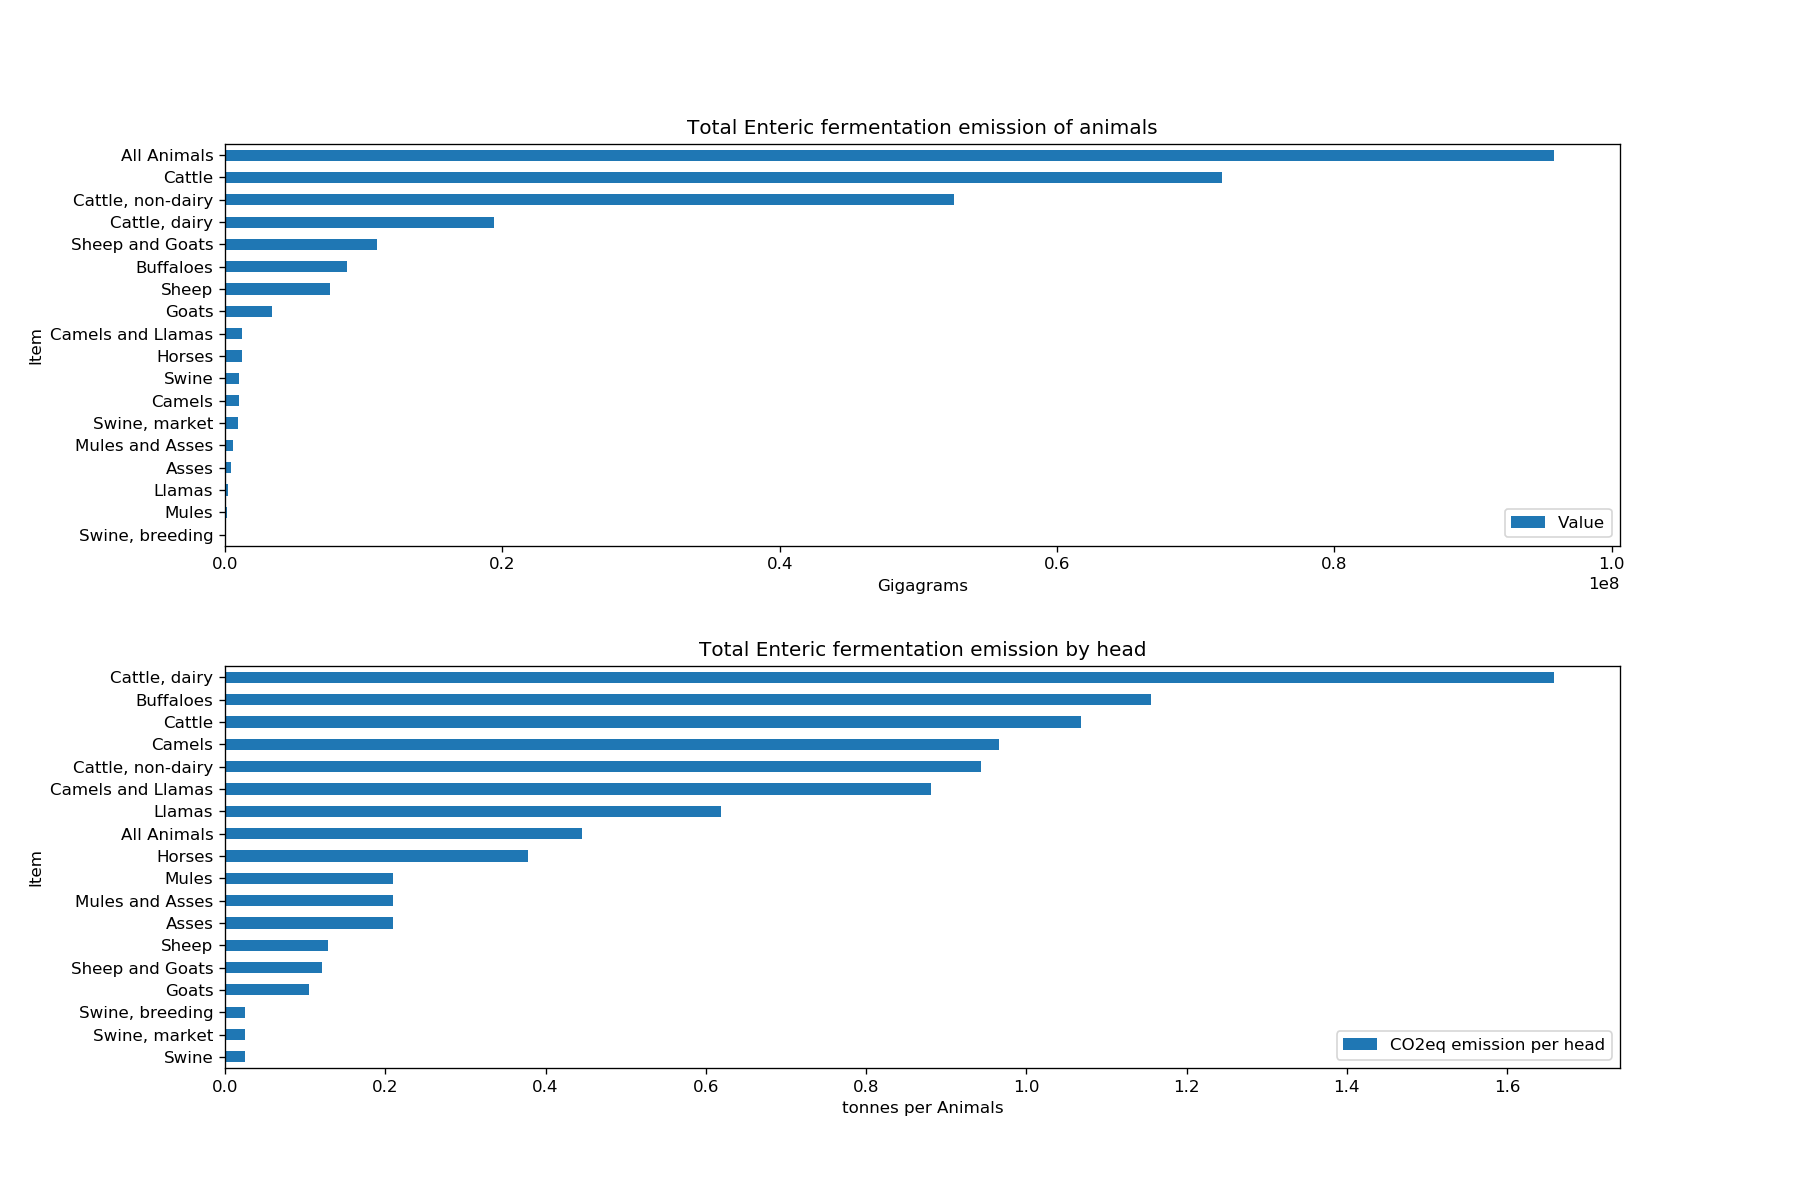

In [82]:
#Grouping stocks count
df_enteric_fermentation_stock_grouped = (
    dfs_enteric_fermentation_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

#Grouping total emissions count
df_enteric_fermentation_emission_grouped = (
    dfs_enteric_fermentation_filtered["emissions"]
    .groupby(["Item"])
    ['Value']
    .sum()
    .reset_index()
)

#Merged to get emissions by head
df_enteric_merged = df_enteric_fermentation_emission_grouped.merge(
    df_enteric_fermentation_stock_grouped,
    on="Item",
    suffixes=("_emission", "_stock")
)

# Convert to tonnes per Animal
df_enteric_merged["CO2eq emission per head"] = df_enteric_merged["Value_emission"] / df_enteric_merged["Value_stock"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_enteric_fermentation_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Enteric fermentation emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_enteric_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Enteric fermentation emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("tonnes per Animals")
axes[1].legend(loc="lower right")

### Manure Soils
The table ‘Manure applied to Soils’ contains the following data:


GHG emissions from manure applied to soils consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) added to agricultural soils by farmers.

In [83]:
df_manure_soils.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


#### Checking for null values

In [84]:
print(df_manure_soils.isna().any())
print("Array of years will null values :", df_manure_soils[df_manure_soils["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_soils = df_manure_soils[df_manure_soils["Year"]<2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element column

In [85]:
df_manure_soils["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure applied)',
       'Implied emission factor for N2O (Manure applied)',
       'Direct emissions (N2O) (Manure applied)',
       'Direct emissions (CO2eq) (Manure applied)',
       'Indirect emissions (N2O) (Manure applied)',
       'Indirect emissions (CO2eq) (Manure applied)',
       'Emissions (N2O) (Manure applied)',
       'Emissions (CO2eq) (Manure applied)'], dtype=object)

Similarly to the previous table, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure applied)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [86]:
#Filter the Element Column
dfs_manure_soils = split_on(
    df_manure_soils[
        df_manure_soils["Element"].isin(["Emissions (CO2eq) (Manure applied)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure applied)": "emissions"
    }
)

print("Stock unit :", dfs_manure_soils.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_soils.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column : Removing groups of animals

In [89]:
print(df_manure_soils["Item"].unique())

Animals = df_manure_soils["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_soils_filtered = DotMap(_dynamic=False)
dfs_manure_soils_filtered["stocks"] = select_on(
    dfs_manure_soils["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_soils_filtered["emissions"] = select_on(
    dfs_manure_soils["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


<IPython.core.display.Javascript object>


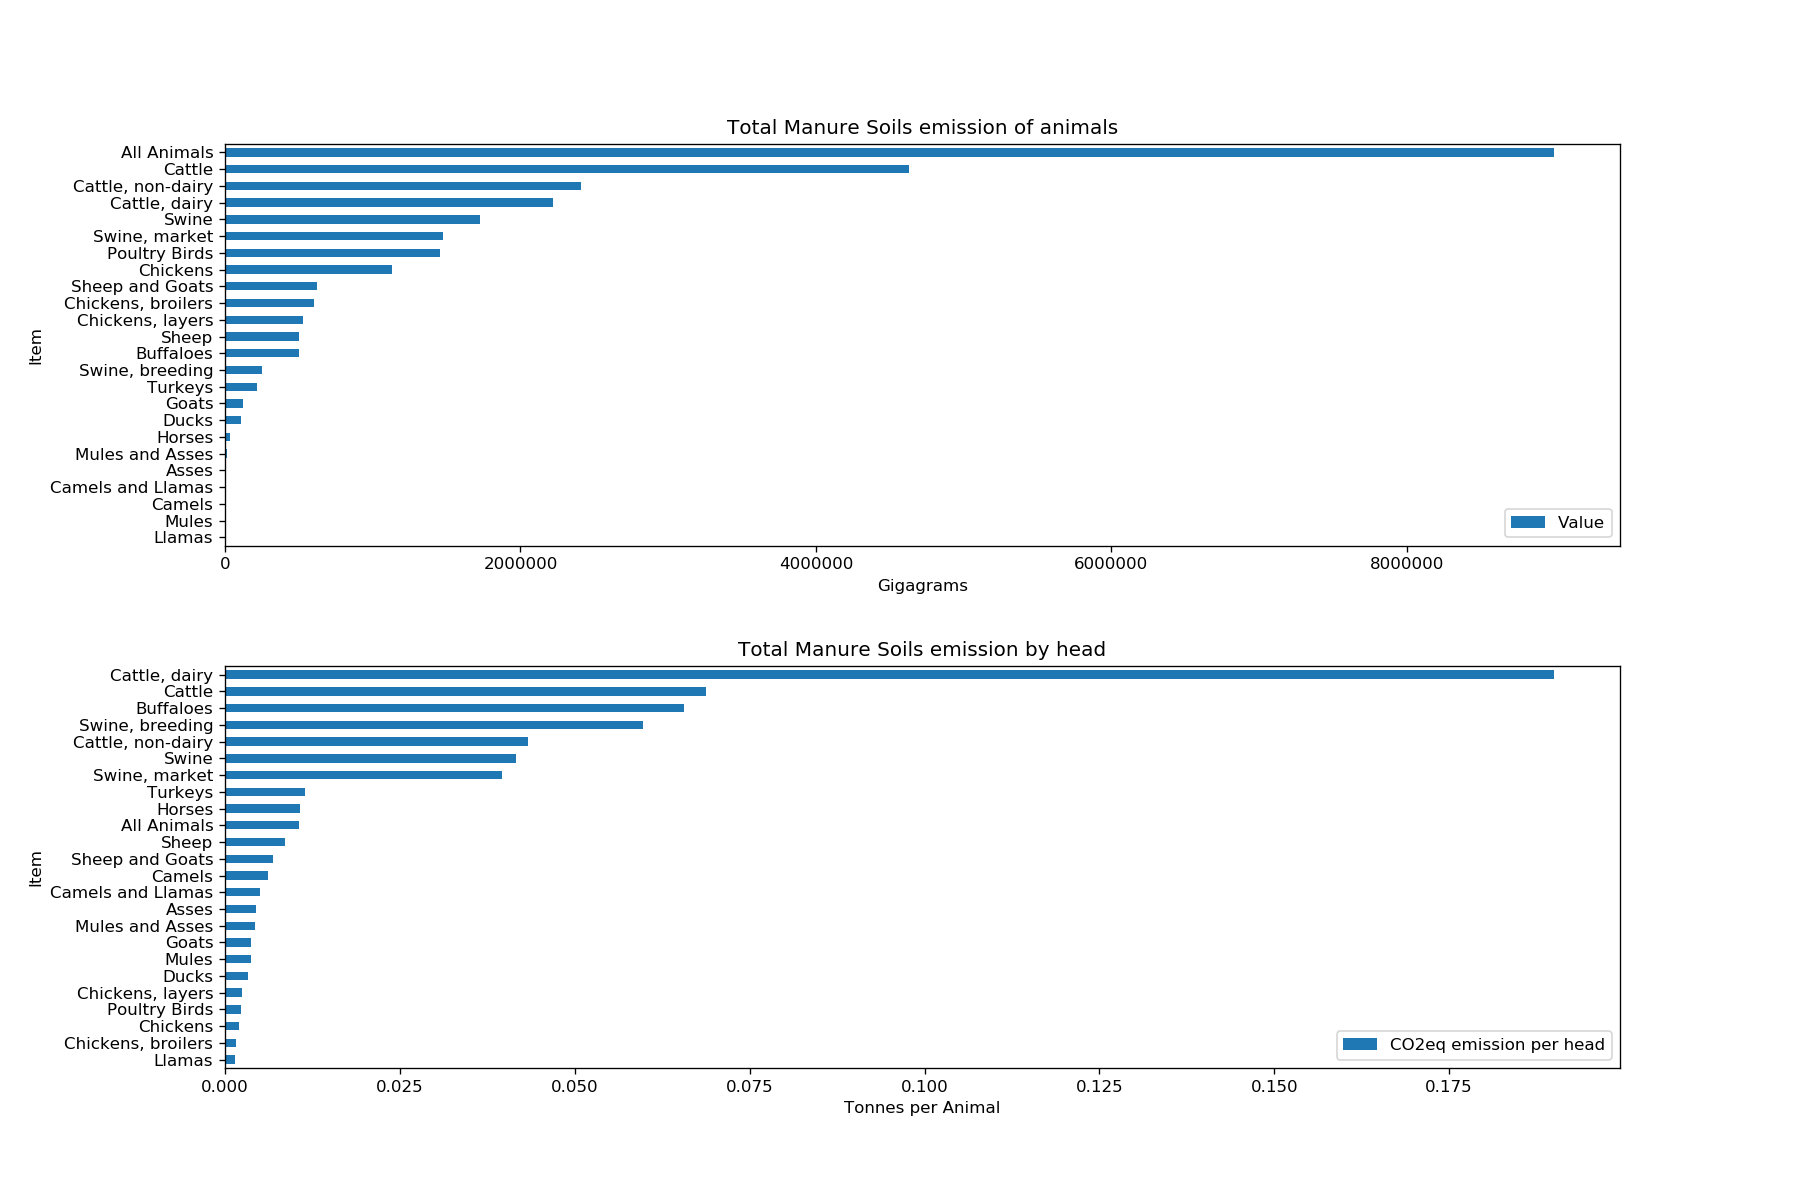

In [90]:
#Grouping stocks count
df_manure_soils_stocks_grouped = (
    dfs_manure_soils_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_soils_emission_grouped = (
    dfs_manure_soils_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_merged = df_manure_soils_emission_grouped.merge(
    df_manure_soils_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per Animal
df_manure_merged["CO2eq emission per head"] = df_manure_merged["Value_emissions"] / df_manure_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_soils_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure Soils emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_manure_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure Soils emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")

### Manure Pasture
The table ‘Manure_Pasture’ contains the following data:

GHG emissions from manure left on pastures consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) left on pastures by grazing livestock.

In [91]:
df_manure_pasture.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1961,Gigagrams,0.0953,Calculated data
1,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1962,Gigagrams,0.0625,Calculated data
2,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1963,Gigagrams,0.0734,Calculated data
3,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1964,Gigagrams,0.0843,Calculated data
4,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1965,Gigagrams,0.0953,Calculated data


#### Checking for null values

In [92]:
print(df_manure_pasture.isna().any())
print("Array of years will null values :",df_manure_pasture[df_manure_pasture["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_pasture = df_manure_pasture[df_manure_pasture["Year"] < 2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element column 

In [93]:
df_manure_pasture["Element"].unique()

array(['Indirect emissions (N2O that leaches) (Manure on pasture)',
       'Indirect emissions (N2O that volatilises) (Manure on pasture)',
       'Manure (N content that leaches) (Manure on pasture)',
       'Manure (N content that volatilises) (Manure on pasture)',
       'Manure (N content) (Manure on pasture)',
       'Implied emission factor for N2O (Manure on pasture)',
       'Direct emissions (N2O) (Manure on pasture)',
       'Direct emissions (CO2eq) (Manure on pasture)',
       'Indirect emissions (N2O) (Manure on pasture)',
       'Indirect emissions (CO2eq) (Manure on pasture)',
       'Emissions (N2O) (Manure on pasture)',
       'Emissions (CO2eq) (Manure on pasture)', 'Stocks'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure on pasture)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [94]:
#Filter the Element Column
dfs_manure_pasture = split_on(
    df_manure_pasture[
        df_manure_pasture["Element"].isin(["Emissions (CO2eq) (Manure on pasture)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure on pasture)": "emissions"
    }
)

print("Stock unit :", dfs_manure_pasture.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_pasture.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column : Removing groups of animals

In [103]:
print(df_manure_pasture["Item"].unique())

Animals = df_manure_pasture["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_pasture_filtered = DotMap(_dynamic=False)
dfs_manure_pasture_filtered["stocks"] = select_on(
    dfs_manure_pasture["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_pasture_filtered["emissions"] = select_on(
    dfs_manure_pasture["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Swine, breeding' 'Swine, market' 'Turkeys' 'Llamas' 'All Animals'
 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses' 'Poultry Birds'
 'Sheep and Goats' 'Swine']


<IPython.core.display.Javascript object>


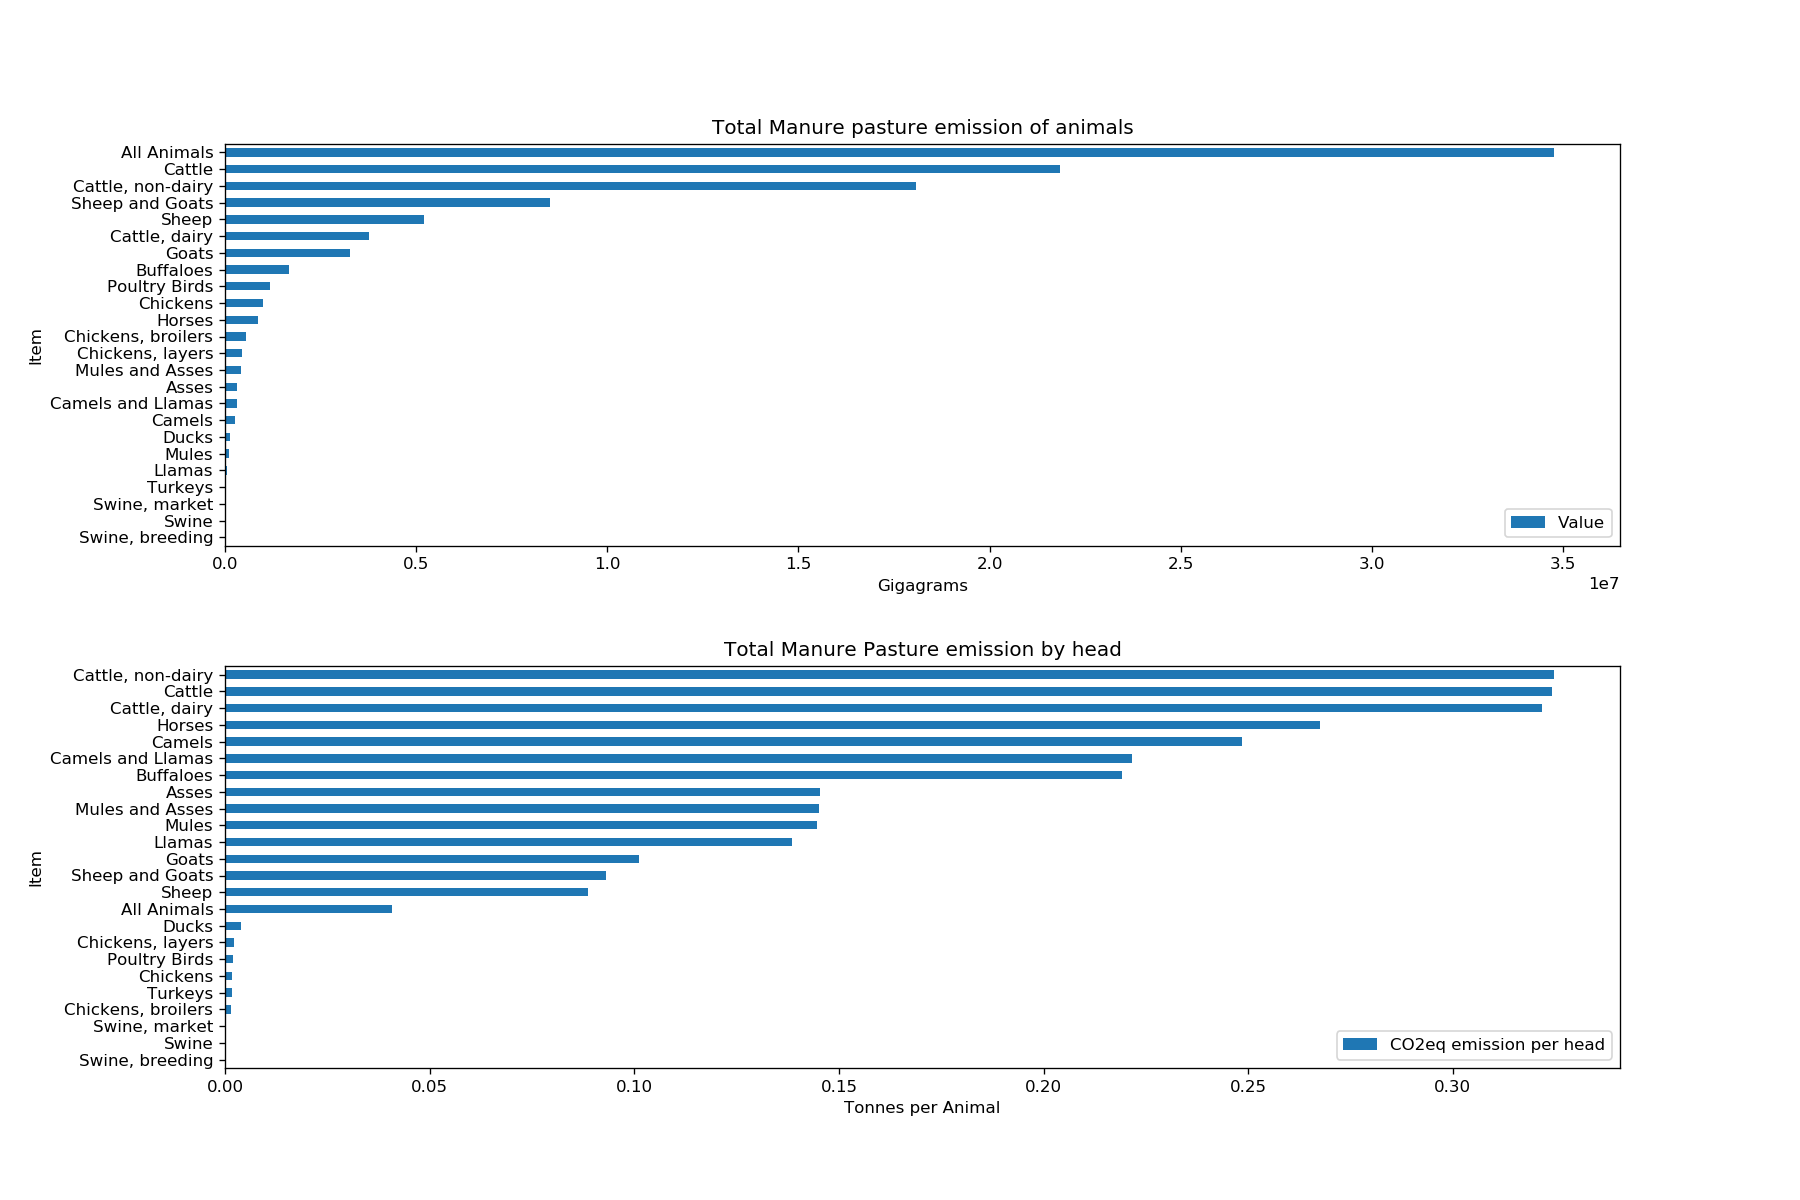

In [104]:
#Grouping stocks count
df_manure_pasture_stocks_grouped = (
    dfs_manure_pasture_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_pasture_emission_grouped = (
    dfs_manure_pasture_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_pasture_merged = df_manure_pasture_emission_grouped.merge(
    df_manure_pasture_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per animals
df_pasture_merged["CO2eq emission per head"] = df_pasture_merged["Value_emissions"] / df_pasture_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_pasture_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure pasture emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_pasture_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure Pasture emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")

### Manure Management
The table ‘Manure_management’ contains the following data:

GHG emissions from manure management consisting of methane and nitrous oxide gases from aerobic and anaerobic manure decomposition processes

In [105]:
df_manure_management.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


#### Checking for null values 

In [106]:
print(df_manure_management.isna().any())
print("Array of years will null values :", df_manure_management[df_manure_management["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_management = df_manure_management[df_manure_management["Year"] < 2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value           False
Flag            False
dtype: bool
Array of years will null values : []


#### Element Column

In [107]:
df_manure_management["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure management)',
       'Implied emission factor for CH4 (Manure management)',
       'Implied emission factor for N2O (Manure management)',
       'Emissions (CH4) (Manure management)',
       'Emissions (CO2eq) from CH4 (Manure management)',
       'Direct emissions (N2O) (Manure management)',
       'Indirect emissions (N2O) (Manure management)',
       'Emissions (N2O) (Manure management)',
       'Direct emissions (CO2eq) (Manure management)',
       'Indirect emissions (CO2eq) (Manure management)',
       'Emissions (CO2eq) from N2O (Manure management)',
       'Emissions (CO2eq) (Manure management)'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure management)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [108]:
#Filter the Element Column
dfs_manure_management = split_on(
    df_manure_management[
        df_manure_management["Element"].isin(["Emissions (CO2eq) (Manure management)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure management)": "emissions"
    }
)

print("Stock unit :", dfs_manure_management.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_management.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column : Removing groups of animals:

In [109]:
print(df_manure_management["Item"].unique())

Animals = df_manure_management["Item"].unique()

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_management_filtered = DotMap(_dynamic=False)
dfs_manure_management_filtered["stocks"] = select_on(
    dfs_manure_management["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_management_filtered["emissions"] = select_on(
    dfs_manure_management["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


<IPython.core.display.Javascript object>


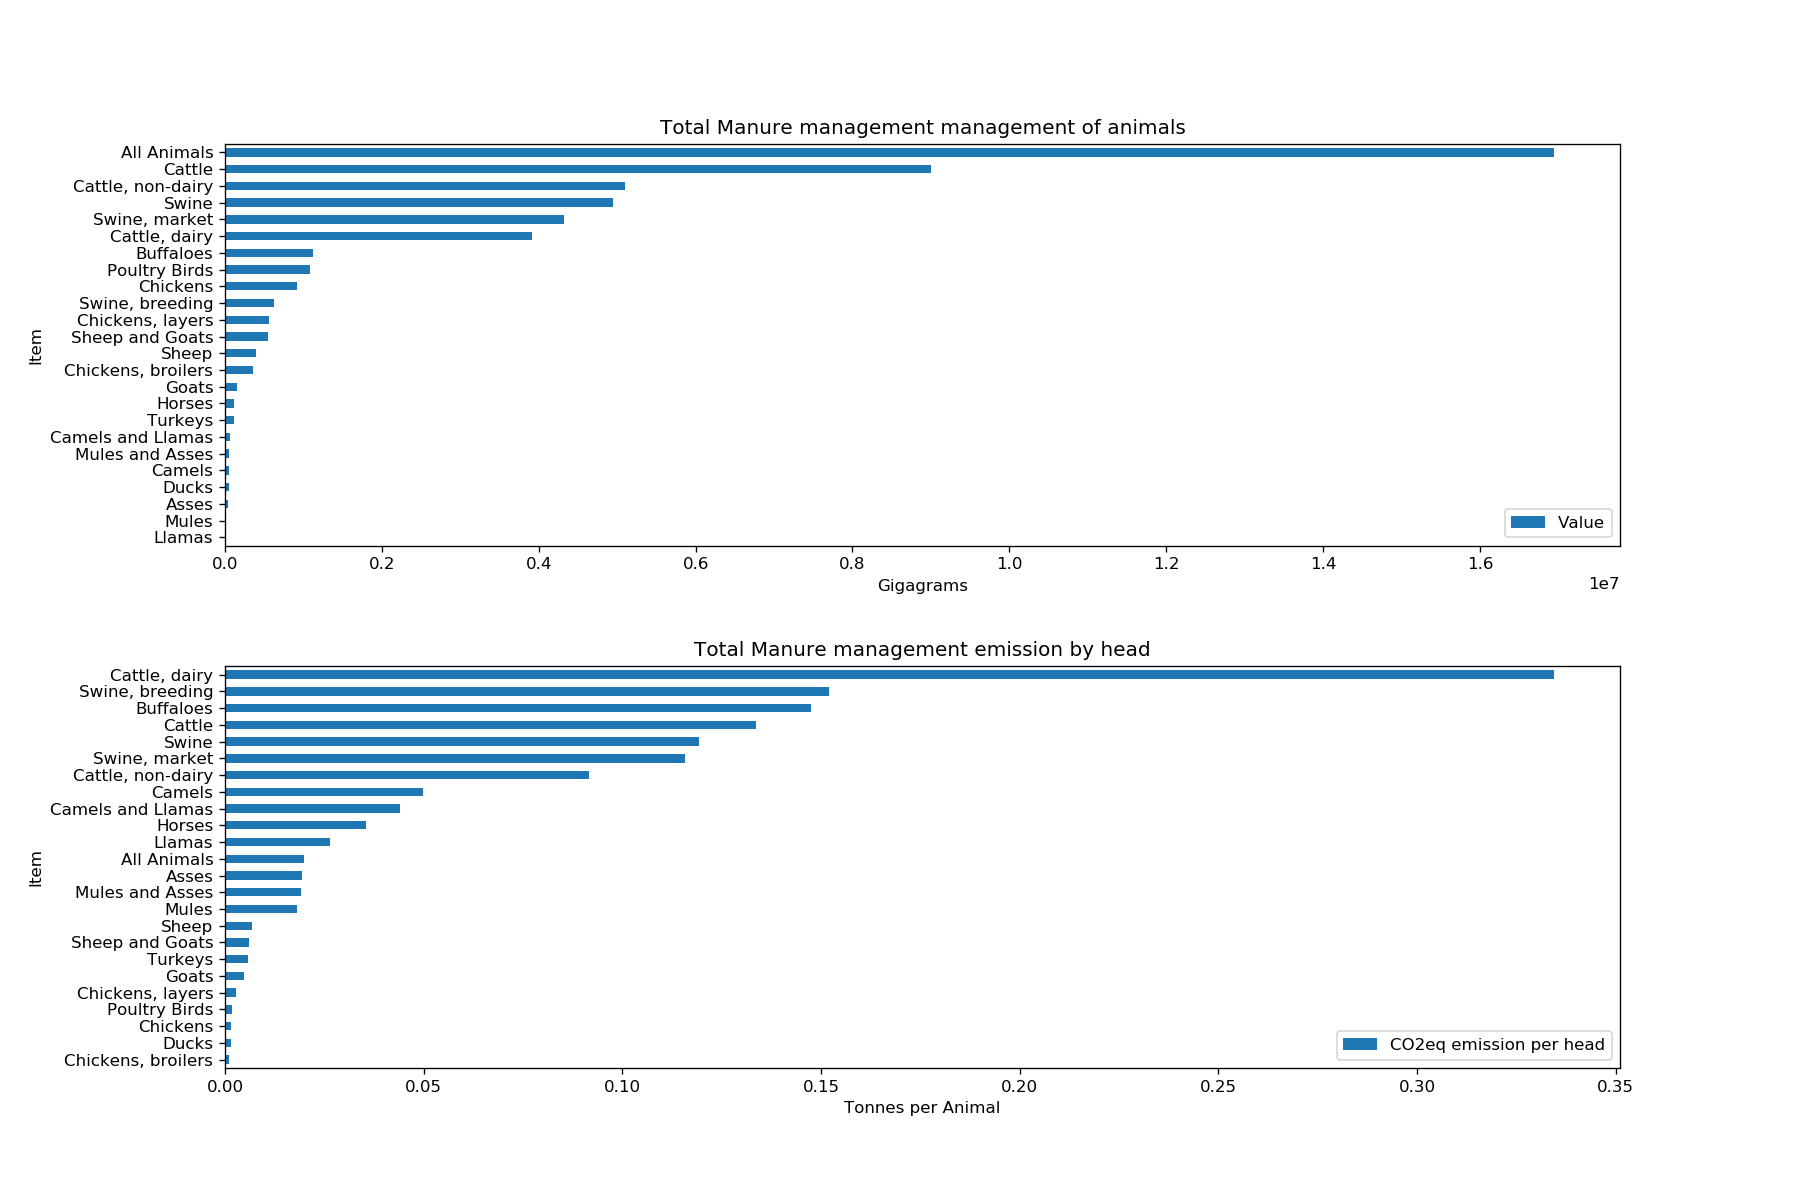

In [110]:
#Grouping stocks count
df_manure_management_stocks_grouped = (
    dfs_manure_management_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_management_emission_grouped = (
    dfs_manure_management_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_management_merged = df_manure_management_emission_grouped.merge(
    df_manure_pasture_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per animals
df_management_merged["CO2eq emission per head"] = df_management_merged["Value_emissions"] / df_management_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_management_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure management management of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_management_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure management emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")


This tables contain information on animals with defferent level of aggregation. We found in FAO documentation definitions for aggregated animal categories:

- All Animals = Asses	+ Buffaloes + Camels + Cattle, dairy + Cattle, non-dairy + Chickens, broilers + Chickens, layers + Ducks + Goats + Horses + Llamas + Mules + Sheep + Swine, breeding + Swine, market + Turkeys
- Camels and Llamas	=	Camels	+ Llamas
- Cattle = Cattle, dairy +	Cattle, non-dairy
- Chickens	= Chickens, broilers + Chickens, layers	
- Mules and Asses =	Asses + Mules	
- Poultry Birds	= Chickens, broilers	+ Chickens, layers	+ Ducks	+ Turkeys	
- Sheep and Goats =	Goats + Sheep	
- Swine	= Swine, breeding + Swine, market

Because of this mix of raw animals and aggregated categories, we have redundancy in the data.
We want to keep only non overlapping categories. To be compatible with the data we have in the other datasets (production and trade datasets) they must be aggregated to the appropriate level.

Therefore, we keep **'Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Poultry Birds'**, which are among the categories having the most impact in terms of GHG emissions. We will show how we map these living animals categories to their corresponding products.

In [112]:
Animals = ['Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Poultry Birds']

In [113]:
#Filtering all tables to keep only the selected animals
dfs_stock = DotMap(
    {
        "enteric_fermentation": dfs_enteric_fermentation.stocks,
        "manure_management": dfs_manure_management.stocks,
        "manure_pasture": dfs_manure_pasture.stocks,
        "manure_soils": dfs_manure_soils.stocks
    },
    _dynamic=False
)

dfs_emissions = DotMap(
    {
        "enteric_fermentation": dfs_enteric_fermentation.emissions,
        "manure_management": dfs_manure_management.emissions,
        "manure_pasture": dfs_manure_pasture.emissions,
        "manure_soils": dfs_manure_soils.emissions
    },
    _dynamic=False
)

column_filters = {"Item": Animals}
for name, df in dfs_stock.items():
    dfs_stock[name] = select_on(df, column_filter_dict=column_filters)
for name, df in dfs_emissions.items():
    dfs_emissions[name] = select_on(df, column_filter_dict=column_filters)

To focus on a good range of years for our analysis we compute for each year the number of countries where there is available data of livestocks.

<IPython.core.display.Javascript object>


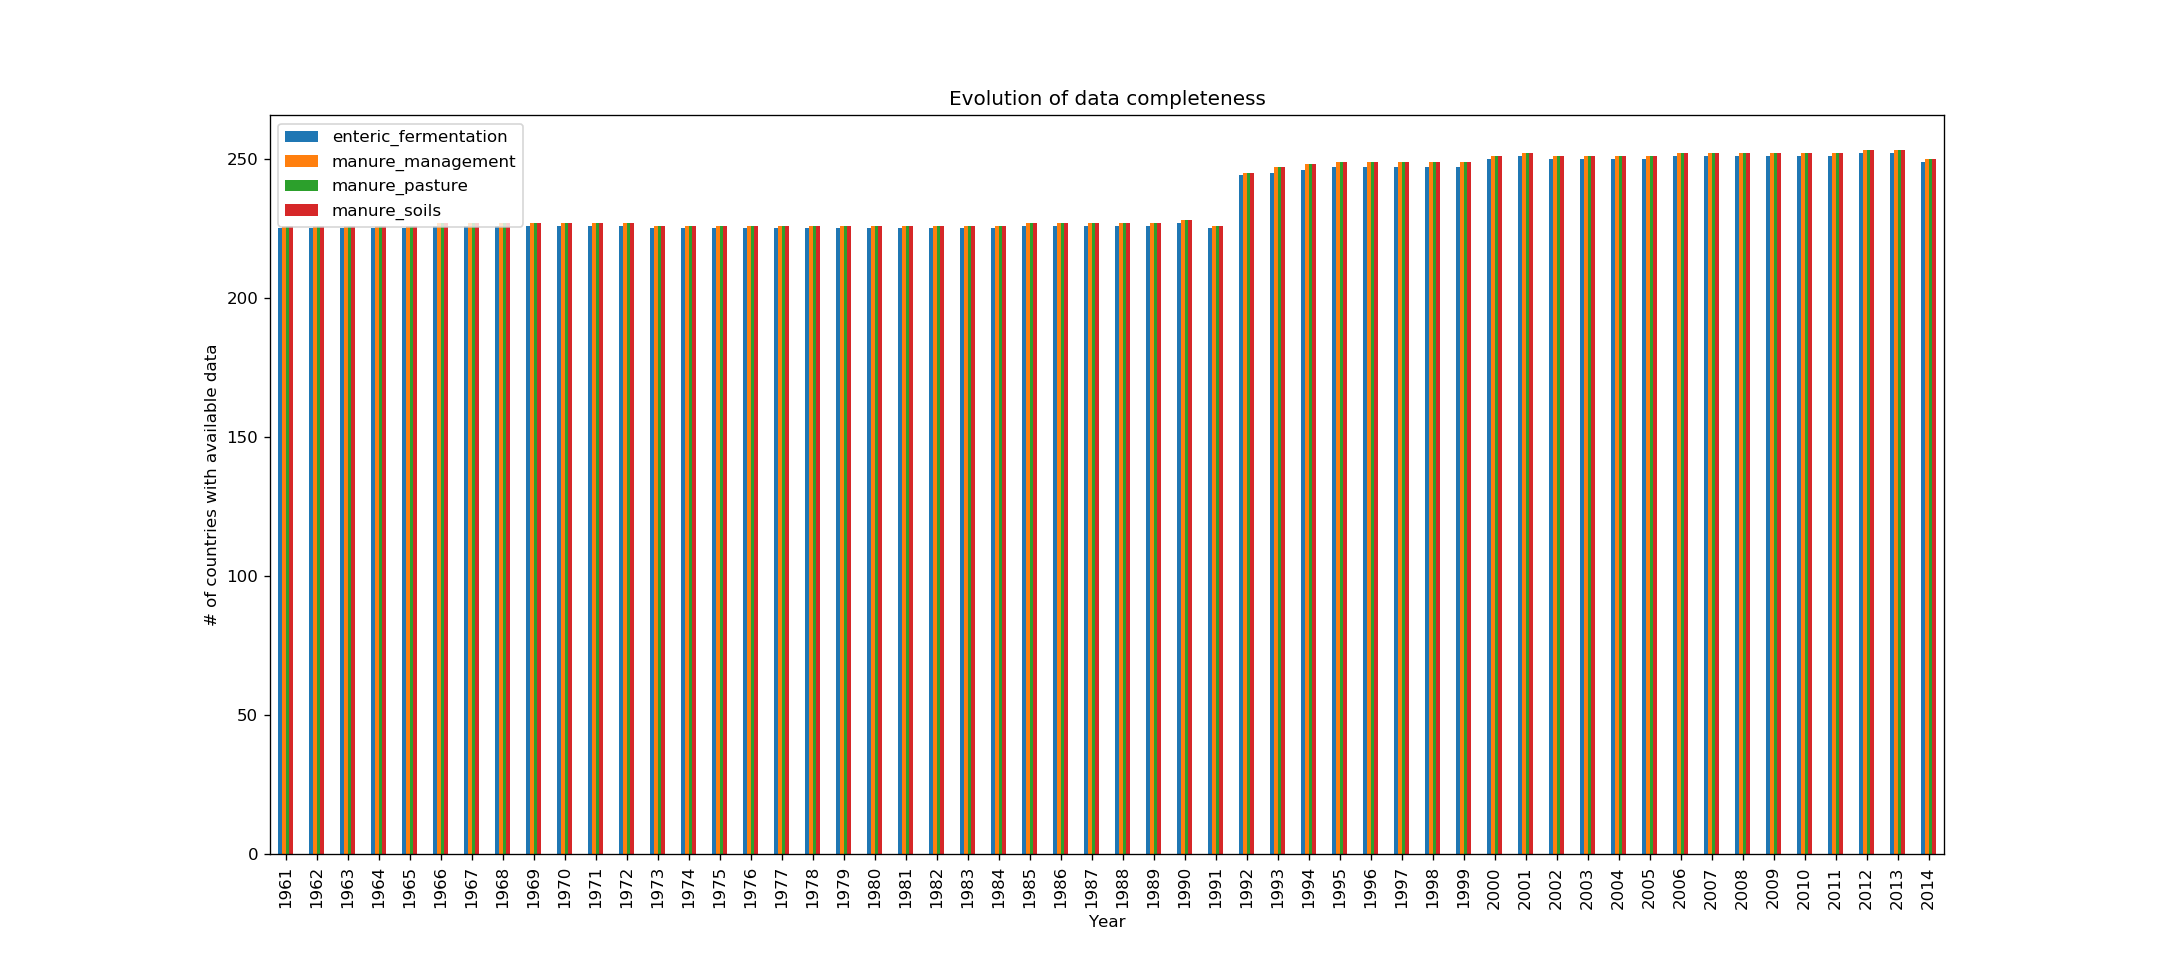

In [114]:
plot_completeness_histogram(dfs_stock, figsize=(18, 8), agg_on="Country Code")

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [115]:
df = dfs_stock.enteric_fermentation
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Country"].unique()) - set(df_before["Country"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Central Asia',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require care in the visualization: the choice of countries to use will most likely be done on a per year basis.

## Computed emissions data

In [116]:
# load base info, drop redundant year code column
df_env_emission_intensity = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Environment_Emissions_intensities_E_All_Data_(Normalized).csv",
    df_flags
).drop("Year Code", axis="columns")

#Remove aggreagated data
df_env_emission_intensity = remove_country_group(df_env_emission_intensity, df_area_groups)

# Split on the Element column
dfs_env_em_intensity = split_on(
    df_env_emission_intensity, "Element",
    drop="Element Code",
    rename=to_snakecase
)
del df_env_emission_intensity
    
for table_name, df in dfs_env_em_intensity.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    if table_name == "emissions_intensity":
        print("  - Available products:", end="\n      ")
        for k, prod in enumerate(df['Item'].unique()):
            print("%-25s" % prod, end="\n      " if k % 4 == 3 else "")
        print()
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table emissions_intensity
  - Units: kg CO2eq/kg product
  - Available products:
      Cereals excluding rice   Rice, paddy              Meat, cattle             Milk, whole fresh cow    
      Meat, goat               Milk, whole fresh goat   Meat, sheep              Milk, whole fresh sheep  
      Milk, whole fresh camel  Meat, chicken            Eggs, hen, in shell      Milk, whole fresh buffalo
      Meat, pig                Meat, buffalo            
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
154876,182,Réunion,1020,"Milk, whole fresh goat",1963,kg CO2eq/kg product,7.4940,Calculated data
38686,351,China,947,"Meat, buffalo",2011,kg CO2eq/kg product,101.0676,Calculated data
71259,74,Gabon,1062,"Eggs, hen, in shell",2007,kg CO2eq/kg product,1.8773,Calculated data
1930,3,Albania,951,"Milk, whole fresh buffalo",1981,kg CO2eq/kg product,4.0375,Calculated data
170251,201,Somalia,867,"Meat, cattle",1963,kg CO2eq/kg product,101.1837,Calculated data
184335,176,Timor-Leste,977,"Meat, sheep",2006,kg CO2eq/kg product,133.2430,Calculated data
184445,176,Timor-Leste,1058,"Meat, chicken",1979,kg CO2eq/kg product,3.4889,Calculated data
24662,239,British Virgin Islands,1017,"Meat, goat",1966,kg CO2eq/kg product,59.3701,Calculated data
13985,14,Barbados,1718,Cereals excluding rice,1962,kg CO2eq/kg product,0.9780,Calculated data
18684,17,Bermuda,1017,"Meat, goat",1986,kg CO2eq/kg product,33.5499,Calculated data




Table emissions_(co2eq)
  - Units: gigagrams
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
24878,239,British Virgin Islands,977,"Meat, sheep",1991,gigagrams,1.1701,Calculated data
83318,91,Guyana,1718,Cereals excluding rice,1997,gigagrams,37.2977,Calculated data
31770,115,Cambodia,882,"Milk, whole fresh cow",1962,gigagrams,197.5825,Calculated data
82484,175,Guinea-Bissau,1020,"Milk, whole fresh goat",1985,gigagrams,11.6189,Calculated data
3625,4,Algeria,1058,"Meat, chicken",1973,gigagrams,49.1530,Calculated data
194801,229,United Kingdom,1062,"Eggs, hen, in shell",1963,gigagrams,452.2251,Calculated data
20995,19,Bolivia (Plurinational State of),882,"Milk, whole fresh cow",1980,gigagrams,106.7552,Calculated data
129220,148,Nauru,1058,"Meat, chicken",1965,gigagrams,0.0038,Calculated data
73268,79,Germany,867,"Meat, cattle",2003,gigagrams,16889.1946,Calculated data
61017,60,El Salvador,27,"Rice, paddy",1984,gigagrams,19.5647,Calculated data




Table production
  - Units: tonnes
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
298280,167,Czechia,1062,"Eggs, hen, in shell",1998,tonnes,221778.0,Official data
305325,101,Indonesia,1058,"Meat, chicken",1984,tonnes,269600.0,Official data
328287,4,Algeria,1130,"Milk, whole fresh camel",1998,tonnes,6600.0,FAO estimate
360529,249,Yemen,1130,"Milk, whole fresh camel",1990,tonnes,8275.0,FAO data based on imputation methodology
324516,223,Turkey,947,"Meat, buffalo",2000,tonnes,4047.0,Official data
312559,149,Nepal,882,"Milk, whole fresh cow",1997,tonnes,310183.0,Official data
292488,255,Belgium,977,"Meat, sheep",2002,tonnes,3200.0,Official data
328460,7,Angola,882,"Milk, whole fresh cow",2006,tonnes,198000.0,FAO estimate
312862,150,Netherlands,882,"Milk, whole fresh cow",1975,tonnes,10221000.0,Official data
328062,3,Albania,1058,"Meat, chicken",1980,tonnes,7800.0,FAO estimate


<IPython.core.display.Javascript object>


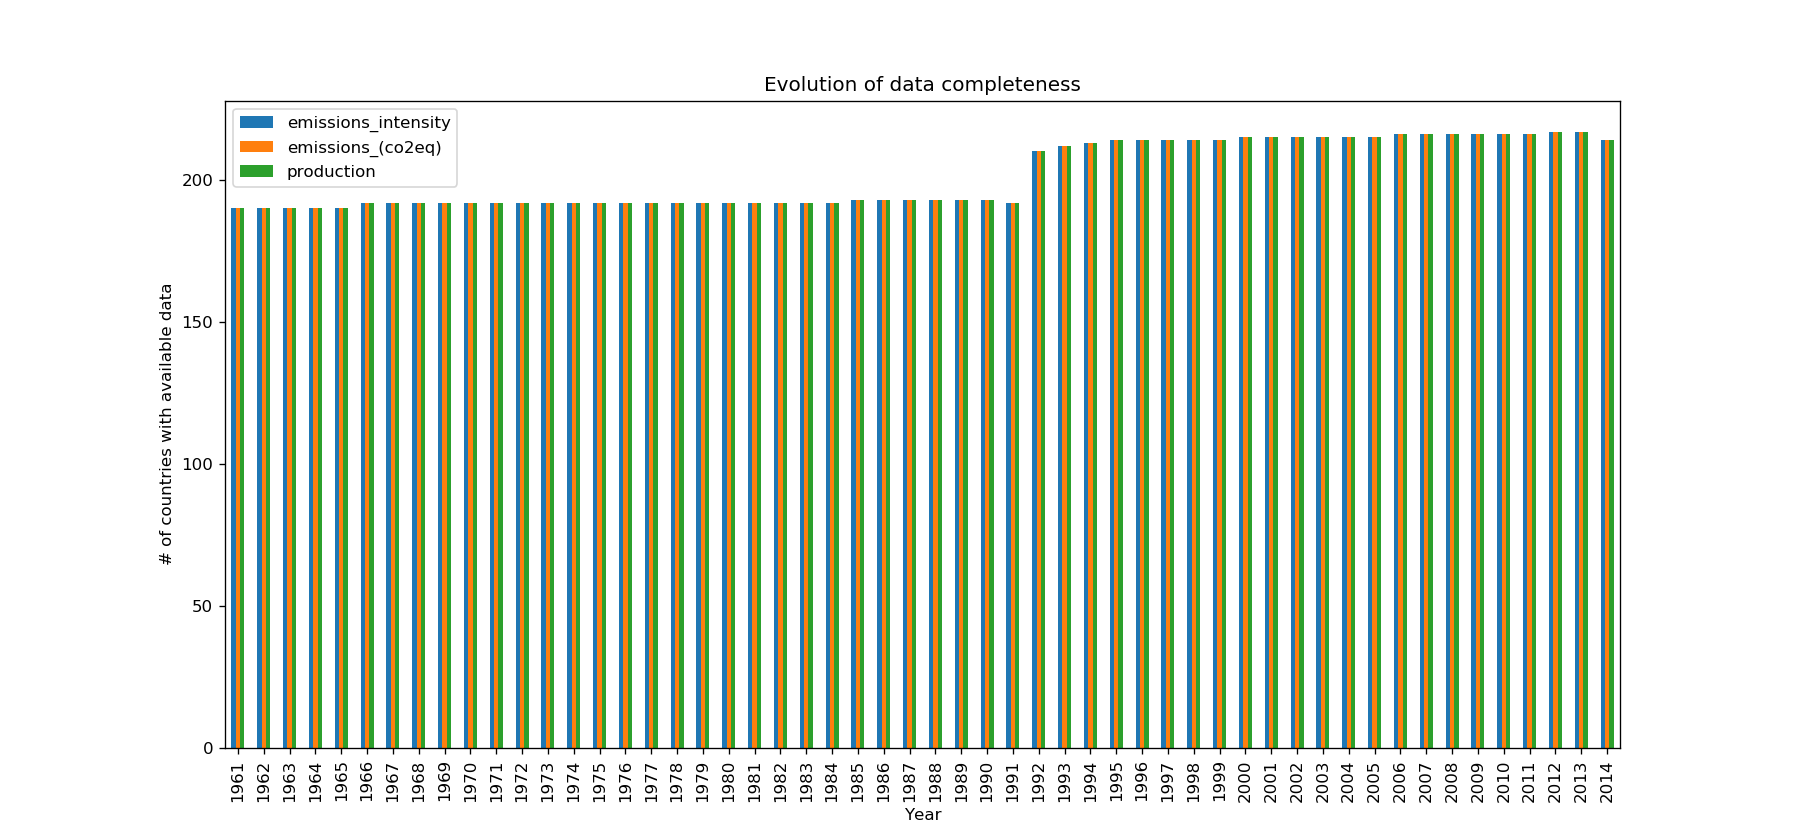

[]

In [117]:
plot_completeness_histogram(dfs_env_em_intensity, figsize=(15, 7))
plt.plot()

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [118]:
df = dfs_env_em_intensity.production
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Area"].unique()) - set(df_before["Area"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require special handling in the analysis and visualization: the choice of countries to use will most likely be done on a per year basis.

## Productions

In [29]:
# Load, remove duplicate column "year code"
df_prod_animals = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Production_LivestockPrimary_E_All_Data_(Normalized).csv",
    df_flags
).drop(columns="Year Code")


#remove aggregated data
df_prod_animals = remove_country_group(df_prod_animals, df_area_groups)

# Harmonise units
## 1000 Head -> Head
unit_filter = df_prod_animals["Unit"] == "1000 Head"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "Head"

## 1000 No -> No
unit_filter = df_prod_animals["Unit"] == "1000 No"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "No"

## 100mg/An 0.1g/An -> g/An
unit_filter = df_prod_animals["Unit"].isin(["100mg/An", "0.1g/An"])
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "g/An"

## hg/An -> kg/An
unit_filter = df_prod_animals["Unit"] == "hg/An"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg/An"

## hg -> kg
unit_filter = df_prod_animals["Unit"] == "hg"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg"

# Split according to Element column
dfs_prod_animals = split_on(
    df_prod_animals,
    "Element",
    rename=to_snakecase
)


for table_name, df in dfs_prod_animals.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    #if table_name == "production":
    print("  - Available products:", end="\n      ")
    for k, prod in enumerate(df['Item'].unique()):
        print("%-36s" % prod.strip(), end="\n      " if k % 3 == 2 else "")
    print()
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table laying
  - Units: Head
  - Available products:
      Eggs, hen, in shell                 Eggs, other bird, in shell          Eggs, hen, in shell (number)        
      Eggs Primary                        
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
34125,48,Costa Rica,1062,"Eggs, hen, in shell",5313,1982,Head,2800000.0,FAO estimate
32021,45,Comoros,1062,"Eggs, hen, in shell",5313,2009,Head,196000.0,FAO estimate
926505,155,Vanuatu,1783,Eggs Primary,5313,1985,Head,72000.0,"Aggregate, may include official, semi-official..."
816109,44,Colombia,1783,Eggs Primary,5313,1991,Head,15298000.0,"Aggregate, may include official, semi-official..."
213561,150,Netherlands,1062,"Eggs, hen, in shell",5313,2014,Head,46570000.0,Official data
851783,104,Ireland,1783,Eggs Primary,5313,2009,Head,3745000.0,"Aggregate, may include official, semi-official..."
32633,46,Congo,1062,"Eggs, hen, in shell",5313,1969,Head,180000.0,FAO estimate
796404,19,Bolivia (Plurinational State of),1783,Eggs Primary,5313,2011,Head,16700000.0,"Aggregate, may include official, semi-official..."
251975,231,United States of America,1062,"Eggs, hen, in shell",5313,1967,Head,313717000.0,Official data
928762,243,Wallis and Futuna Islands,1783,Eggs Primary,5313,1983,Head,7000.0,"Aggregate, may include official, semi-official..."




Table production
  - Units: tonnes, No, Head
  - Available products:
      Eggs, hen, in shell                 Eggs, hen, in shell (number)        Honey, natural                      
      Meat indigenous, camel              Meat indigenous, cattle             Meat indigenous, chicken            
      Meat indigenous, goat               Meat indigenous, sheep              Meat, cattle                        
      Meat, game                          Meat, goat                          Meat, sheep                         
      Milk, whole fresh cow               Milk, whole fresh goat              Milk, whole fresh sheep             
      Silk-worm cocoons, reelable         Wool, greasy                        Eggs, other bird, in shell          
      Eggs, other bird, in shell (number) Meat indigenous, pig                Meat, chicken                       
      Meat, nes                           Meat, pig                           Milk, whole fresh buffalo           
      Mea

,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
295941,80,Bosnia and Herzegovina,919,"Hides, cattle, fresh",5510,2003,tonnes,3151.0,Calculated data
382492,70,French Polynesia,1032,"Meat indigenous, goat",5510,1964,tonnes,43.0,Calculated data
925140,234,Uruguay,1775,"Meat indigenous, poultry",5510,1965,tonnes,8638.0,"Aggregate, may include official, semi-official..."
191993,99,Iceland,1055,"Meat indigenous, pig",5510,1994,tonnes,3212.0,Official data
20174,233,Burkina Faso,944,"Meat indigenous, cattle",5322,1984,Head,296955.0,FAO estimate
330170,41,"China, mainland",1032,"Meat indigenous, goat",5510,1981,tonnes,219611.0,Calculated data
711678,28,Myanmar,867,"Meat, cattle",5510,2011,tonnes,210000.0,Unofficial figure
183384,68,France,1080,"Meat, turkey",5510,1996,tonnes,662500.0,Official data
404602,175,Guinea-Bissau,1035,"Meat, pig",5510,1980,tonnes,7840.0,Calculated data
229907,182,Réunion,882,"Milk, whole fresh cow",5510,1976,tonnes,4680.0,Official data




Table producing_animals/slaughtered
  - Units: Head
  - Available products:
      Hides, cattle, fresh                Meat, camel                         Meat, cattle                        
      Meat, chicken                       Meat, goat                          Meat, sheep                         
      Skins, goat, fresh                  Skins, sheep, fresh                 Meat, pig                           
      Meat, horse                         Meat, rabbit                        Meat, turkey                        
      Meat, duck                          Meat, goose and guinea fowl         Skins, sheep, with wool             
      Hides, buffalo, fresh               Meat, buffalo                       Meat, other camelids                
      Meat, other rodents                 Meat, ass                           Meat, mule                          
      Meat, bird nes                      Meat, game                          Meat, nes                           
  

,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
13097,53,Benin,995,"Skins, sheep, fresh",5320,2007,Head,263650.0,FAO estimate
119769,197,Sierra Leone,1017,"Meat, goat",5320,1964,Head,21000.0,FAO estimate
22414,35,Cabo Verde,1035,"Meat, pig",5320,1982,Head,36740.0,FAO estimate
26429,39,Chad,919,"Hides, cattle, fresh",5320,2005,Head,680000.0,FAO estimate
84262,135,Martinique,919,"Hides, cattle, fresh",5320,2003,Head,9000.0,FAO estimate
50152,70,French Polynesia,977,"Meat, sheep",5320,1985,Head,250.0,FAO estimate
51178,74,Gabon,995,"Skins, sheep, fresh",5320,1964,Head,11750.0,FAO estimate
827056,56,Dominican Republic,1807,Sheep and Goat Meat,5320,1978,Head,122000.0,"Aggregate, may include official, semi-official..."
475520,141,Mongolia,867,"Meat, cattle",5320,1998,Head,755600.0,Calculated data
912131,211,Switzerland,1807,Sheep and Goat Meat,5320,1968,Head,193977.0,"Aggregate, may include official, semi-official..."




Table milk_animals
  - Units: Head
  - Available products:
      Milk, whole fresh camel             Milk, whole fresh cow               Milk, whole fresh goat              
      Milk, whole fresh sheep             Milk, whole fresh buffalo           Milk,Total                          
      
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
141129,228,USSR,982,"Milk, whole fresh sheep",5318,1975,Head,1600000.0,FAO estimate
187112,84,Greece,882,"Milk, whole fresh cow",5318,1968,Head,452127.0,Official data
228940,117,Republic of Korea,882,"Milk, whole fresh cow",5318,1993,Head,320000.0,Official data
98434,158,Niger,882,"Milk, whole fresh cow",5318,1983,Head,789000.0,FAO estimate
7333,11,Austria,982,"Milk, whole fresh sheep",5318,1967,Head,7100.0,FAO estimate
847694,97,Hungary,1780,"Milk,Total",5318,2009,Head,382000.0,"Aggregate, may include official, semi-official..."
158395,80,Bosnia and Herzegovina,982,"Milk, whole fresh sheep",5318,2014,Head,281000.0,Official data
213371,149,Nepal,882,"Milk, whole fresh cow",5318,1988,Head,682937.0,Official data
170139,98,Croatia,882,"Milk, whole fresh cow",5318,1994,Head,327634.0,Official data
238482,203,Spain,882,"Milk, whole fresh cow",5318,1986,Head,1957000.0,Official data




Table prod_popultn
  - Units: Head, No
  - Available products:
      Wool, greasy                        Honey, natural                      Beeswax                             
      Silk-worm cocoons, reelable         Hair, horse                         
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
194353,102,Iran (Islamic Republic of),987,"Wool, greasy",5319,1966,Head,28990000.0,Official data
781791,237,Viet Nam,1185,"Silk-worm cocoons, reelable",5319,2005,Head,NaN,Data not available
29486,41,"China, mainland",1182,"Honey, natural",5314,1982,No,6100000.0,FAO estimate
729286,47,Cook Islands,1182,"Honey, natural",5314,2001,No,11.0,FAO data based on imputation methodology
774044,105,Israel,1182,"Honey, natural",5314,1991,No,NaN,Data not available
72201,112,Jordan,987,"Wool, greasy",5319,2005,Head,1580000.0,FAO estimate
772028,59,Egypt,1185,"Silk-worm cocoons, reelable",5319,1990,Head,NaN,Data not available
769629,32,Cameroon,1182,"Honey, natural",5314,1986,No,NaN,Data not available
774102,106,Italy,1182,"Honey, natural",5314,1973,No,NaN,Data not available
216913,156,New Zealand,987,"Wool, greasy",5319,2002,Head,39572000.0,Official data




Table yield
  - Units: g/An, kg/An, kg
  - Available products:
      Eggs, hen, in shell                 Hides, cattle, fresh                Milk, whole fresh camel             
      Milk, whole fresh cow               Milk, whole fresh goat              Milk, whole fresh sheep             
      Skins, goat, fresh                  Skins, sheep, fresh                 Wool, greasy                        
      Eggs Primary                        Milk,Total                          Milk, whole fresh buffalo           
      Skins, sheep, with wool             Eggs, other bird, in shell          Hides, buffalo, fresh               
      Honey, natural                      Beeswax                             
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
492124,150,Netherlands,1780,"Milk,Total",5420,2002,kg/An,6906.2,Calculated data
439379,114,Kenya,999,"Skins, sheep, with wool",5420,1966,kg/An,800.0,Calculated data
437427,114,Kenya,919,"Hides, cattle, fresh",5420,2008,kg/An,21.0,Calculated data
383401,70,French Polynesia,995,"Skins, sheep, fresh",5420,2007,kg/An,2.5,Calculated data
419618,102,Iran (Islamic Republic of),1182,"Honey, natural",5422,2005,kg,9.9,Calculated data
504691,162,Norway,919,"Hides, cattle, fresh",5420,1980,kg/An,15.0,Calculated data
364067,58,Ecuador,1780,"Milk,Total",5420,1985,kg/An,3066.5,Calculated data
449418,123,Liberia,919,"Hides, cattle, fresh",5420,2012,kg/An,20.0,Calculated data
413098,99,Iceland,919,"Hides, cattle, fresh",5420,1994,kg/An,17.2,Calculated data
460476,131,Malaysia,1025,"Skins, goat, fresh",5420,1970,kg/An,2.3,Calculated data




Table yield/carcass_weight
  - Units: kg/An, g/An
  - Available products:
      Meat indigenous, camel              Meat indigenous, cattle             Meat indigenous, chicken            
      Meat indigenous, goat               Meat indigenous, sheep              Meat, camel                         
      Meat, cattle                        Meat, chicken                       Meat, goat                          
      Meat, sheep                         Beef and Buffalo Meat               Meat, Poultry                       
      Sheep and Goat Meat                 Meat indigenous, pig                Meat, pig                           
      Meat indigenous, horse              Meat indigenous, rabbit             Meat indigenous, turkey             
      Meat, horse                         Meat, rabbit                        Meat, turkey                        
      Meat indigenous, duck               Meat indigenous, geese              Meat, duck                          
    

,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
618388,236,Venezuela (Bolivarian Republic of),1017,"Meat, goat",5417,2004,kg/An,11.6,Calculated data
514617,168,Papua New Guinea,1035,"Meat, pig",5417,1984,kg/An,40.0,Calculated data
419955,102,Iran (Islamic Republic of),1094,"Meat indigenous, chicken",5424,1970,g/An,1400.0,Calculated data
274681,11,Austria,1087,"Meat indigenous, turkey",5424,1978,g/An,5670.5,Calculated data
584542,216,Thailand,1070,"Meat indigenous, duck",5424,1978,g/An,1500.0,Calculated data
594345,222,Tunisia,1094,"Meat indigenous, chicken",5424,1961,g/An,1200.0,Calculated data
594893,222,Tunisia,1087,"Meat indigenous, turkey",5424,1987,g/An,5800.0,Calculated data
600485,227,Tuvalu,1808,"Meat, Poultry",5424,2011,g/An,909.1,Calculated data
346637,49,Cuba,1808,"Meat, Poultry",5424,1982,g/An,1197.3,Calculated data
616766,155,Vanuatu,1058,"Meat, chicken",5424,1965,g/An,1000.0,Calculated data


In [28]:
df_pr = dfs_prod_animals.production
df_y = dfs_prod_animals["yield"]

s = set(df_pr["Item Code"].unique()) -  set(df_y["Item Code"].unique())

df_pr[ df_pr['Item Code'].isin(s)]["Item"].unique()

array(['Eggs, hen, in shell (number)', 'Meat indigenous, camel',
       'Meat indigenous, cattle', 'Meat indigenous, chicken',
       'Meat indigenous, goat', 'Meat indigenous, sheep', 'Meat, cattle',
       'Meat, game', 'Meat, goat', 'Meat, sheep',
       'Silk-worm cocoons, reelable',
       'Eggs, other bird, in shell (number)', 'Meat indigenous, pig',
       'Meat, chicken', 'Meat, nes', 'Meat, pig',
       'Meat indigenous, horse', 'Meat indigenous, rabbit',
       'Meat indigenous, turkey', 'Meat, camel', 'Meat, horse',
       'Meat indigenous, duck', 'Meat indigenous, geese', 'Meat, duck',
       'Meat, turkey', 'Meat, goose and guinea fowl', 'Meat, rabbit',
       'Meat indigenous, buffalo', 'Meat, buffalo',
       'Meat indigenous, other camelids', 'Meat indigenous, rodents',
       'Meat, other camelids', 'Meat indigenous, ass',
       'Meat indigenous, bird nes', 'Meat indigenous, mule', 'Meat, ass',
       'Meat, mule', 'Snails, not sea', 'Meat, bird nes', 'Hair, horse',
 

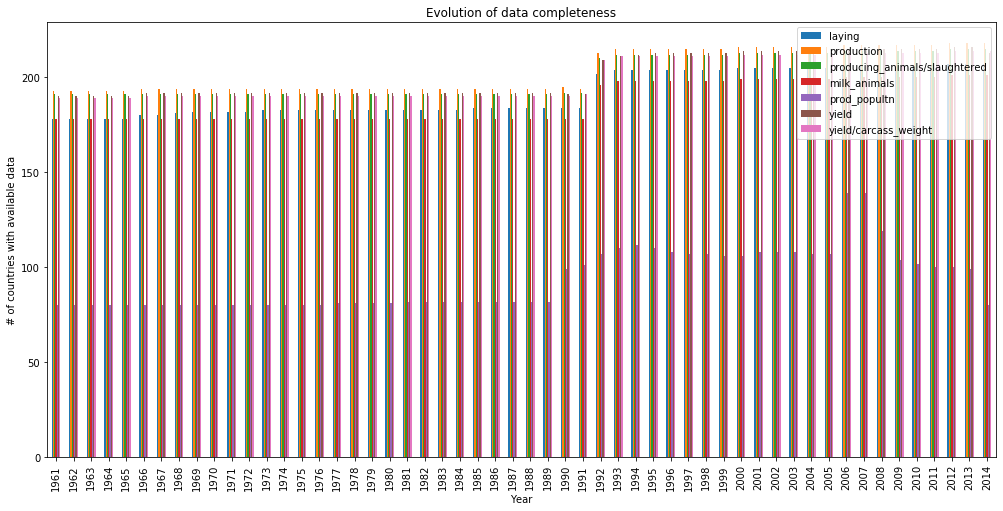

In [41]:
plot_completeness_histogram(dfs_prod_animals, figsize=(17,8))

The above bar plot shows that the `prod_popultn` Table has a lot of missing countries. Given the data it holds, namely the production of `['Wool, greasy', 'Honey, natural', 'Beeswax', 'Silk-worm cocoons, reelable', 'Hair, horse']`, this is not a problem.

The tables we are mostly interested in are `production`, `yield` and `producing_animals/slaughtered`, so we will have to consider only contries at least in those three tables.

## Trade data

In [24]:
raw_trade_matrix = pd.read_csv("data/detailed_trade_matrix/Trade_DetailedTradeMatrix_E_All_Data_NOFLAG.csv", encoding="Latin1")
raw_trade_matrix.sample(5)

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Unit,Y1986,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
281971,13,Bahrain,238,Ethiopia,910,Ice cream and edible ice,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1931118,84,Greece,58,Ecuador,570,Figs dried,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962058,84,Greece,210,Sweden,867,"Meat, cattle",5910,Export Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,1.0,9.0,1.0,5.0
4837407,225,United Arab Emirates,68,France,653,Food wastes,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN
1595823,68,France,15,Belgium-Luxembourg,231,Almonds shelled,5610,Import Quantity,tonnes,542.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
raw_trade_matrix["Element"].unique()

array(['Export Quantity', 'Export Value', 'Import Quantity',
       'Import Value'], dtype=object)

Detailed trade matrix contains trade information in terms of **quantity** and in terms of **value**. According to FAO documentation, information in terms of value is sometime inconsistent because some countries report values including insurance/transport costs and others report values excluding these costs. Therefore, we will use only **quantity** information.

In [26]:
dfs_trade = split_on(raw_trade_matrix, 
                     "Element", 
                     rename={"Export Quantity":"export","Import Quantity":"import"}, 
                     only_named=True, 
                     drop=["Element Code","Element"])

In [27]:
del raw_trade_matrix

dfs_trade contains two dataframes:
- dfs_trade.export contains trade information reported by exporter country
- dfs_trade.import contains trade information reported by importer country

There is redundancy in this information because a transaction is normally reported both by importer and exporter country.

We want to remove this redundancy, without sacrificing information.

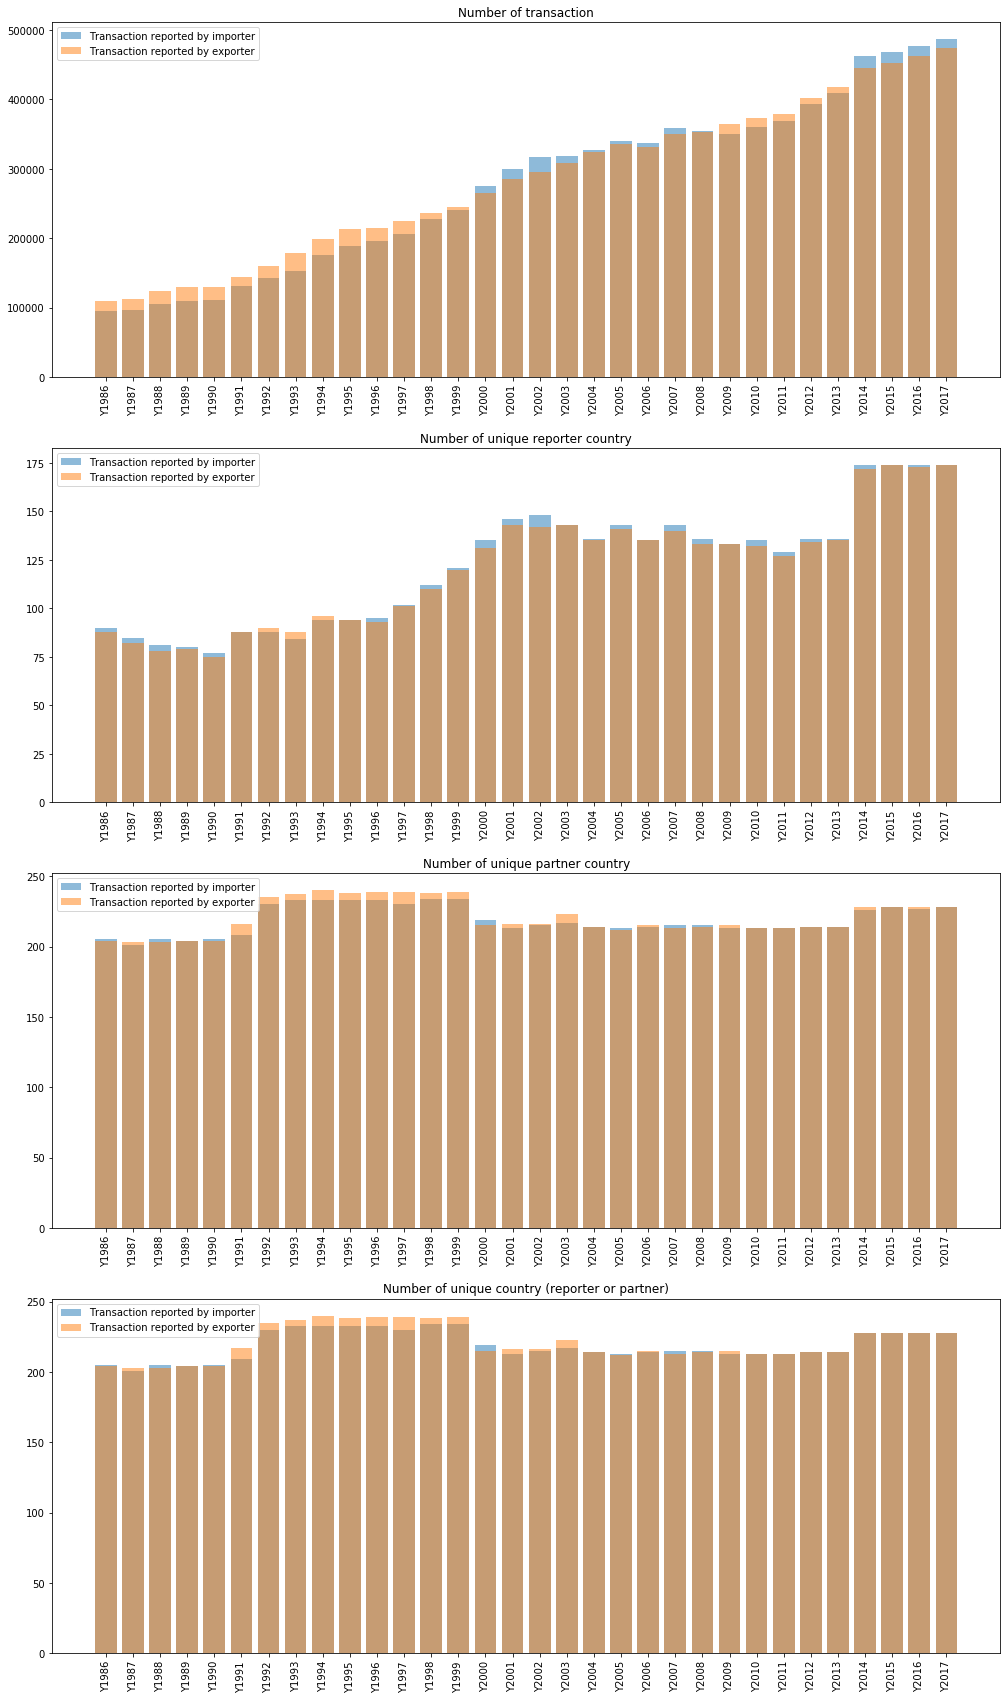

In [64]:
years = ['Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992', 'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997',
         'Y1998', 'Y1999', 'Y2000', 'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008', 'Y2009',
         'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015', 'Y2016', 'Y2017']

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(17,30))

for direction in ["import","export"]:
    n_rows = []
    n_reporter = []
    n_partner = []
    n_countries = []

    for year in years :
        n_rows.append(len(dfs_trade[direction][dfs_trade[direction][year].notna()]))
        reporters = dfs_trade[direction][dfs_trade[direction][year].notna()]["Reporter Countries"].unique()
        partners = dfs_trade[direction][dfs_trade[direction][year].notna()]["Partner Countries"].unique()
        n_reporter.append(len(reporters))
        n_partner.append(len(partners))
        n_countries.append(len(np.unique(np.concatenate((reporters,partners)))))
        
    axs[0].bar(years, n_rows, alpha=0.5)
    axs[0].set_title("Number of transaction")
    axs[1].bar(years, n_reporter, alpha=0.5)
    axs[1].set_title("Number of unique reporter country")
    axs[2].bar(years, n_partner, alpha=0.5)
    axs[2].set_title("Number of unique partner country")
    axs[3].bar(years, n_countries, alpha=0.5)
    axs[3].set_title("Number of unique country (reporter or partner)")

for ax in axs:
    ax.set_xticklabels(labels=years,rotation=90)
    ax.legend(["Transaction reported by importer","Transaction reported by exporter"])
plt.show()

# Livestock food estimate

Using [http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf](http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf), we can try to estimate the food consuption of some livestock

## Beef

Using the above reference, section 4 for the equations, Table 2 for variable definitons, and Tables 3a and 3b for assumption, we get:

$$
\begin{align}
    \mathit{DM} &= \sum_{ration} \left(
                    \mathit{DMI}_\mathit{ration}
                    \times \mathit{DOF}_\mathit{ration}
                    \times \left(1 - \frac{\mathit{DMD}_\mathit{ration}}{100}\right)
                   \right)
                    +
                   \sum_{ration} \left(
                    \mathit{DOF}_\mathit{ration}
                    \times 20.3 \times 0.06
                    \times \mathit{BW}_\mathit{AVG}
                  \right)
\end{align}
$$
where:
+ $\mathit{DM}$: total dry matter excretion
+ $\mathit{DMI}$: Dry Matter Ingestion, for a given ration
+ $\mathit{DOF}$: Day On Feed, number of days a ration lasts
+ $\mathit{DMD}$: Dry Matter Digestibility
+ $\mathit{BW}_\mathit{AVG}$: Body Weight average for the duration of the ration

Given the second part handles the dry content of urine (6%) and since the average body weigth is 471kg, the factor 20.3 is highly dubious - a cattle does not excrete 20 times its mass in urine a day.

After research, we found cattle produce a bit more than 20L gallons a day of urine, and $\frac{471~\mathit{kg}}{20.3 ~ \mathit{kg} . L^{-1}} = 23.2~L$. We therefore correct the above equation to *divide* the body weigth by 20.3.

We first formally split all multi-days ration into 1 day rations, so that $\mathit{DOF} := 1$. Then with Table 3b we estimate the dry matter digestibility to be 80%, hence $\mathit{DMD} = 80$ in the equation. Finally, from Table 3b, $\mathit{DMI} = 0.02 \mathit{BW}_\mathit{AVG}$.

We get:

$$
\begin{align}
    \mathit{DM} &= \sum_{ration} \left(
                    0.2 \times 0.02 \times \mathit{BW}_\mathit{AVG}
                    +
                    \frac{0.06}{20.3} \mathit{BW}_\mathit{AVG}
                  \right) \\
    \mathit{DM} &= 6.956 \times 10^{-3} \times \sum_{ration} \mathit{BW}_\mathit{AVG} \\
    \sum_\mathit{ration} \mathit{BW}_\mathit{AVG} &= 3.383 \times 10^2 \times \mathit{DM}
\end{align}
$$

Injecting the relationship between $\mathit{DM}$ and $\mathit{BW}$, we get:

$$
\begin{align}
    \sum_{ration} \mathit{DMI} &= 0.02 \times \sum_{ration} \mathit{BW}_\mathit{AVG} \\
    \sum_{ration} \mathit{DMI} &= 6.7667 \times \mathit{DM}
\end{align}
$$

This holds for the whole life of the cattle. Inputing the water content of 92% for manure, we finally get (keeping more precision digit from previous calculations):

$$
    \sum_{ration} \mathit{DMI} = 0.54133 \times \mathit{Manure}
$$

In [42]:
def cattle_consumption_from_manure(manure):
    """
    Yield the food consumption in kg of dry matter of non-dairy cattle
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.54133

## Dairy cattle

The above reference, section 5 yields:
$$
    \mathit{DM}_\mathit{per~day} = 0.350 \times \mathit{DMI} + 1.017
$$

Including the milk production is a bit more precise according to the reference, but requires estimating the content of true protein on our end:

$$
    \mathit{DM}_\mathit{per~day} =
        0.135 \times \mathit{Milk}
        + 0.004 \times \mathit{BW}
        + 0.004 \times \mathit{DIM}
        + 118.370 \times \mathit{MTP}
        - 2.456
$$

where:
+ $\mathit{MTP}$ is the Milk True Protein in g / g of milk / day

The average body weigth is from the same document 624kg. The moisture content of manure is reported to be 87%.

In [43]:
# Whenever possible, constant and estimated values have been aggregated
def dairy_cattle_consumption_from_manure(manure, animal_count, days=365.25):
    """
    Yields the food consumption in kg of dry matter of dairy cattle
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return ((0.13 * manure) - 1.017 * animal_count * days) / 0.35

def dairy_cattle_consumption_from_manure_milk(manure, animal_count, milk, milk_true_prot, days=365.25):
    """
    Yields the food consumption in kg of dry matter of non-dairy cattle
    from their production of manure and milk
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return (0.17 * manure - 0.135 * milk - 118.370 * milk_true_prot - 0.004 * animal_count * days) / 0.004

## Poultry
This includes Broilers, Turkeys and ducks. The conversion from section 7 is strait-forward

In [44]:
def broiler_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of broiler
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.3116

def turkey_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of turkey, Toms and Hens
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.2521

def duck_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of duck
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.3063

## Poultry (laying hen)

Using the equation from 8.3.1 and injecting all the estimates from Table 11, we get a simple affine function. Manure is estimated as 75% moisture.

$$
    \mathit{DM}_\mathit{per~day} = \mathit{DMI} - 0.85 \times \mathit{DMI}
    \times \frac{
        140 + 53 \times \mathit{Egg}_\mathit{prod}
    }{
        \mathit{KCAL}_i
    }
    - 0.3319 \times \mathit{Egg}_{prod} \times \mathit{Egg}_\mathit{wt}
$$

Table 11 gives
+ $\mathit{Egg}_\mathit{prod} = 0.8$
+ $\mathit{Egg}_\mathit{wt} = 61.5 g$
+ $\mathit{KCAL}_i = 281 \mathit{KCal}$

hence:

$$
    \mathit{DM}_\mathit{per~day} = 0.350889 \times \mathit{DMI} - 16.32948
$$

Assuming a $75%$ moisture content and summing over the year on all animals, we get:

$$
    \mathit{DMI}_\mathit{tot} = \frac{0.25 \mathit{manure} + 16.32948 \times \mathit{days} \times \mathit{\# animals}}{0.350889}
$$

In [45]:
def laying_consumption_from_manure(manure, animal_count, days=365.25):
    """
    Yields the yearly food consumption in kg of dry matter of laying hen
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return (manure / 4 + 16.3295 * days * animal_count) / 0.3509

## Swine

We differenciate between nursery pig (5 - 20kg) and grow-finishing pig (20 - 120 kg).
Using section 9.3.1, we get:

$$
    \mathit{DM} = \mathit{DMI} * \frac{100 - DMD}{10000}
                    + 0.025 \times \mathit{DOF} \times \left(
                        20 \mathit{BW}_\mathit{AVG} + 2100
                      \right)
$$

Inputing the assumptions from Table 18b:
+ $\mathit{DMD} = 82$
+ $\mathit{DOF} = 120$
+ $\mathit{DMI} = 0.034 \mathit{BW}$

Solving first for $\mathit{BW}$ and then going back to $\mathit{DMI}$, we get:

$$
    \mathit{DMI} = 0.034 \times \frac{\mathit{DM} - 6300}{60}
$$

For nursery swine, equation 9.4.1 with assumptions from Table 18b yields simply:

$$
    \mathit{DMI} = \frac{1000}{72} \mathit{DM}
$$

From Table 18a, we hestimate that the manure is $(120 - 56) / 120 = 53\%$ moisture

In [46]:
def swine_consumption_from_manure(manure, swine_count):
    """
    Yields the yearly food consumption in kg of dry matter of laying hen
    from their production of manure and the total number of swine
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return 0.034 * (manure * 56 / 120 - 6300 * swine_count) / 60

def nursery_swine_consumption_from_manure(manure):
    return 1000 / 72 * manure